# Skin lesion image classification

The data will be downloaded from the [
ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection challenge
](https://challenge2018.isic-archive.com/) [1].

The goal of this recurring challenge is to help participants develop image analysis tools to enable the automated diagnosis of melanoma from dermoscopic images.

The lesion images come from the HAM10000 Dataset [2], and were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Images were collected with approval of the Ethics Review Committee of University of Queensland (Protocol-No. 2017001223) and Medical University of Vienna (Protocol-No. 1804/2017).

There are 7 classes:

- MEL: “Melanoma” diagnosis confidence
- NV: “Melanocytic nevus” diagnosis confidence
- BCC: “Basal cell carcinoma” diagnosis confidence
- AKIEC: “Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)” diagnosis confidence
- BKL: “Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)” diagnosis confidence
- DF: “Dermatofibroma” diagnosis confidence
- VASC: “Vascular lesion” diagnosis confidence

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

Here are some examples (taken from the ISIC2018 website):

<br/>
<br/>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*le3-EQ-rpTLKtgB4G8jKkw.png">
<br/>
<br/>

[1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).


In [1]:
# when using the kaggle environment this is not needed, only for colab
#!pip install torch-xla pytorch-lightning torch==2.3.0 torchvision lightning numpy

## Import TensorFlow and other libraries

In [2]:
import random
import os
import pathlib

from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader
from torch import nn
from torch.nn import functional as F

from torchvision import transforms, datasets

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import cv2

## Download and parse the dataset

In the following cell we download the data and unzip it:

In [3]:
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!unzip ISIC2018_Task3_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
!unzip ISIC2018_Task3_Training_GroundTruth.zip
!mkdir data

--2024-11-19 12:51:54--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.25.121, 3.5.30.82, 3.5.13.166, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.25.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: 'ISIC2018_Task3_Training_Input.zip'

ISIC2018_Task3_Trai 100%[===================>]   2.58G  49.9MB/s    in 57s     

2024-11-19 12:52:51 (46.4 MB/s) - 'ISIC2018_Task3_Training_Input.zip' saved [2771732744/2771732744]

Archive:  ISIC2018_Task3_Training_Input.zip
   creating: ISIC2018_Task3_Training_Input/
  inflating: ISIC2018_Task3_Training_Input/ATTRIBUTION.txt  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0024306.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0024307.jpg  
 extracting: ISIC2018_Task3_Training_Input/ISIC_0

The unzipped data is put into the data directory in a subfolder that corresponds to its class. Pytorch lightning can infer the class by taking the subfolder name.

In [4]:
# Define directories
data_dir = pathlib.Path("data/")
input_dir = pathlib.Path("ISIC2018_Task3_Training_Input")
ground_truth_file = "ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

# Read ground truth and prepare class folders
with open(ground_truth_file) as f:
    header = f.readline().strip().split(",")

    # Create class directories
    for dir_class in header[1:]:  # Skip the first column (image ID)
        class_dir = data_dir / dir_class
        class_dir.mkdir(parents=True, exist_ok=True)

# Process each image in the ground truth file
with open(ground_truth_file) as f:
    next(f)  # Skip the header
    for row in tqdm(f, desc="Organizing images"):
        row = row.strip().split(",")
        image_id = row[0]
        labels = row[1:]

        src = input_dir / f"{image_id}.jpg"
        if not src.exists():  # Skip if the source file does not exist
            continue

        for idx, label in enumerate(labels):
            if label == "1.0":  # Only process relevant labels
                dst = data_dir / header[idx + 1] / f"{image_id}.jpg"  # Class-specific directory
                os.rename(src, dst)  # Move the file

Organizing images: 10015it [00:00, 26387.32it/s]


There are quite a few images of these spots:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10015


## Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 512
img_height = 180
img_width = 180
pl.seed_everything(42)

42

Define how to preprocess the data:

In [7]:
# Define data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Define the location of the data as an ImageFolder, also apply all transformations:

In [8]:
# Load dataset
data_dir = "data/"
dataset = datasets.ImageFolder(data_dir, transform=transform)

Set a training set size and validation set size, with a standard function from pytorch apply the split:

In [9]:
# Split into training and validation datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Create the actual dataloaders for the training and validation sets.

In [10]:
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

1824


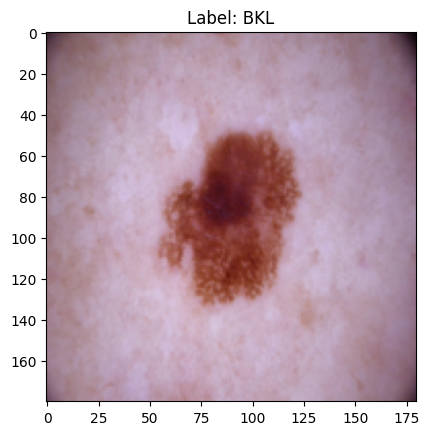

In [11]:
# Display a random image from the dataset
class_names = dataset.classes
def show_random_image(dataset):
    idx = random.randint(0, len(dataset) - 1)
    print(idx)
    image, label = dataset[idx]
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
    plt.title(f"Label: {class_names[label]}")
    plt.show()

show_random_image(dataset)

# Dense network classification

# CNN classification

In [12]:
class MelanomaClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(MelanomaClassifier, self).__init__()
        # Define the first convolutional layer:
        # - Input channels: 3 (RGB image)
        # - Output channels: 32
        # - Kernel size: 6 (large receptive field)
        # - Padding: 1 to maintain spatial dimensions
        self.conv1 = nn.Conv2d(3, 32, kernel_size=6, stride=1, padding=1)

        # Define the second convolutional layer:
        # - Input channels: 32
        # - Output channels: 32 (same as the previous layer)
        # - Kernel size: 3 (smaller receptive field)
        # - Padding: 1 to maintain spatial dimensions
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # Define the third convolutional layer:
        # - Input channels: 32
        # - Output channels: 32
        # - Kernel size: 3
        # - Padding: 1 to maintain spatial dimensions
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)

        # Define a max-pooling layer:
        # - Kernel size: 2x2
        # - Stride: 2 (reduces spatial dimensions by half)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the first fully connected layer (FC1):
        # - Input size: 32 * 22 * 22
        #   (32 output channels from conv3, reduced spatial size to 22x22 after pooling)
        # - Output size: 64 neurons
        self.fc1 = nn.Linear(32 * 22 * 22, 64)

        # Define the second fully connected layer (FC2):
        # - Input size: 64
        # - Output size: num_classes (number of target classes)
        self.fc2 = nn.Linear(64, num_classes)

        # Define a dropout layer to reduce overfitting:
        # - Dropout probability: 0.3
        self.dropout = nn.Dropout(0.3)

        # Define the loss function:
        # - CrossEntropyLoss is used for multi-class classification problems
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        """
        Perform a forward pass through the network.
        :param x: Input tensor (batch of images)
        :return: Output logits for each class
        """
        # Apply the first convolutional layer and max-pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output shape: (Batch, 32, 90, 90)

        # Apply the second convolutional layer and max-pooling
        x = self.pool(F.relu(self.conv2(x)))  # Output shape: (Batch, 32, 45, 45)

        # Apply the third convolutional layer and max-pooling
        x = self.pool(F.relu(self.conv3(x)))  # Output shape: (Batch, 32, 22, 22)

        # Flatten the tensor to prepare it for the fully connected layers
        # Output shape: (Batch, 32 * 22 * 22)
        x = x.view(x.size(0), -1)

        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Apply dropout for regularization
        x = self.dropout(x)

        # Apply the second fully connected layer (output layer)
        # Output shape: (Batch, num_classes)
        x = self.fc2(x)

        return x

    def training_step(self, batch, batch_idx):
        """
        Perform one step of training.
        :param batch: A tuple containing inputs (images) and labels
        :param batch_idx: The index of the batch
        :return: Training loss
        """
        inputs, labels = batch
        outputs = self(inputs)  # Forward pass
        loss = self.criterion(outputs, labels)  # Compute loss
        # Log the training loss for monitoring
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Perform one step of validation.
        :param batch: A tuple containing inputs (images) and labels
        :param batch_idx: The index of the batch
        """
        inputs, labels = batch
        outputs = self(inputs)  # Forward pass
        loss = self.criterion(outputs, labels)  # Compute loss
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        acc = (preds == labels).float().mean()  # Compute accuracy
        # Log validation loss and accuracy
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)

    def predict_step(self, batch, batch_idx):
        """
        Perform a prediction step.
        :param batch: A tuple containing inputs (images) and labels (labels are ignored)
        :param batch_idx: The index of the batch
        :return: Logits for the predictions
        """
        inputs, _ = batch  # Ignore labels during prediction
        return self(inputs)

    def configure_optimizers(self):
        """
        Configure the optimizer for training.
        :return: Adam optimizer with a learning rate of 0.001
        """
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [13]:
# Instantiate the model
num_classes = len(class_names)
model = MelanomaClassifier(num_classes=num_classes)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",        # Monitor validation loss
    dirpath="./",   # Directory to save the checkpoint
    filename="melanoma-model",  # Checkpoint filename
    save_top_k=1,              # Save the best model only
    mode="min",                # Save the model with the minimum validation loss
)


# Initialize Trainer itself
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu",
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Make predictions for the validation set:

Predicting: |          | 0/? [00:00<?, ?it/s]

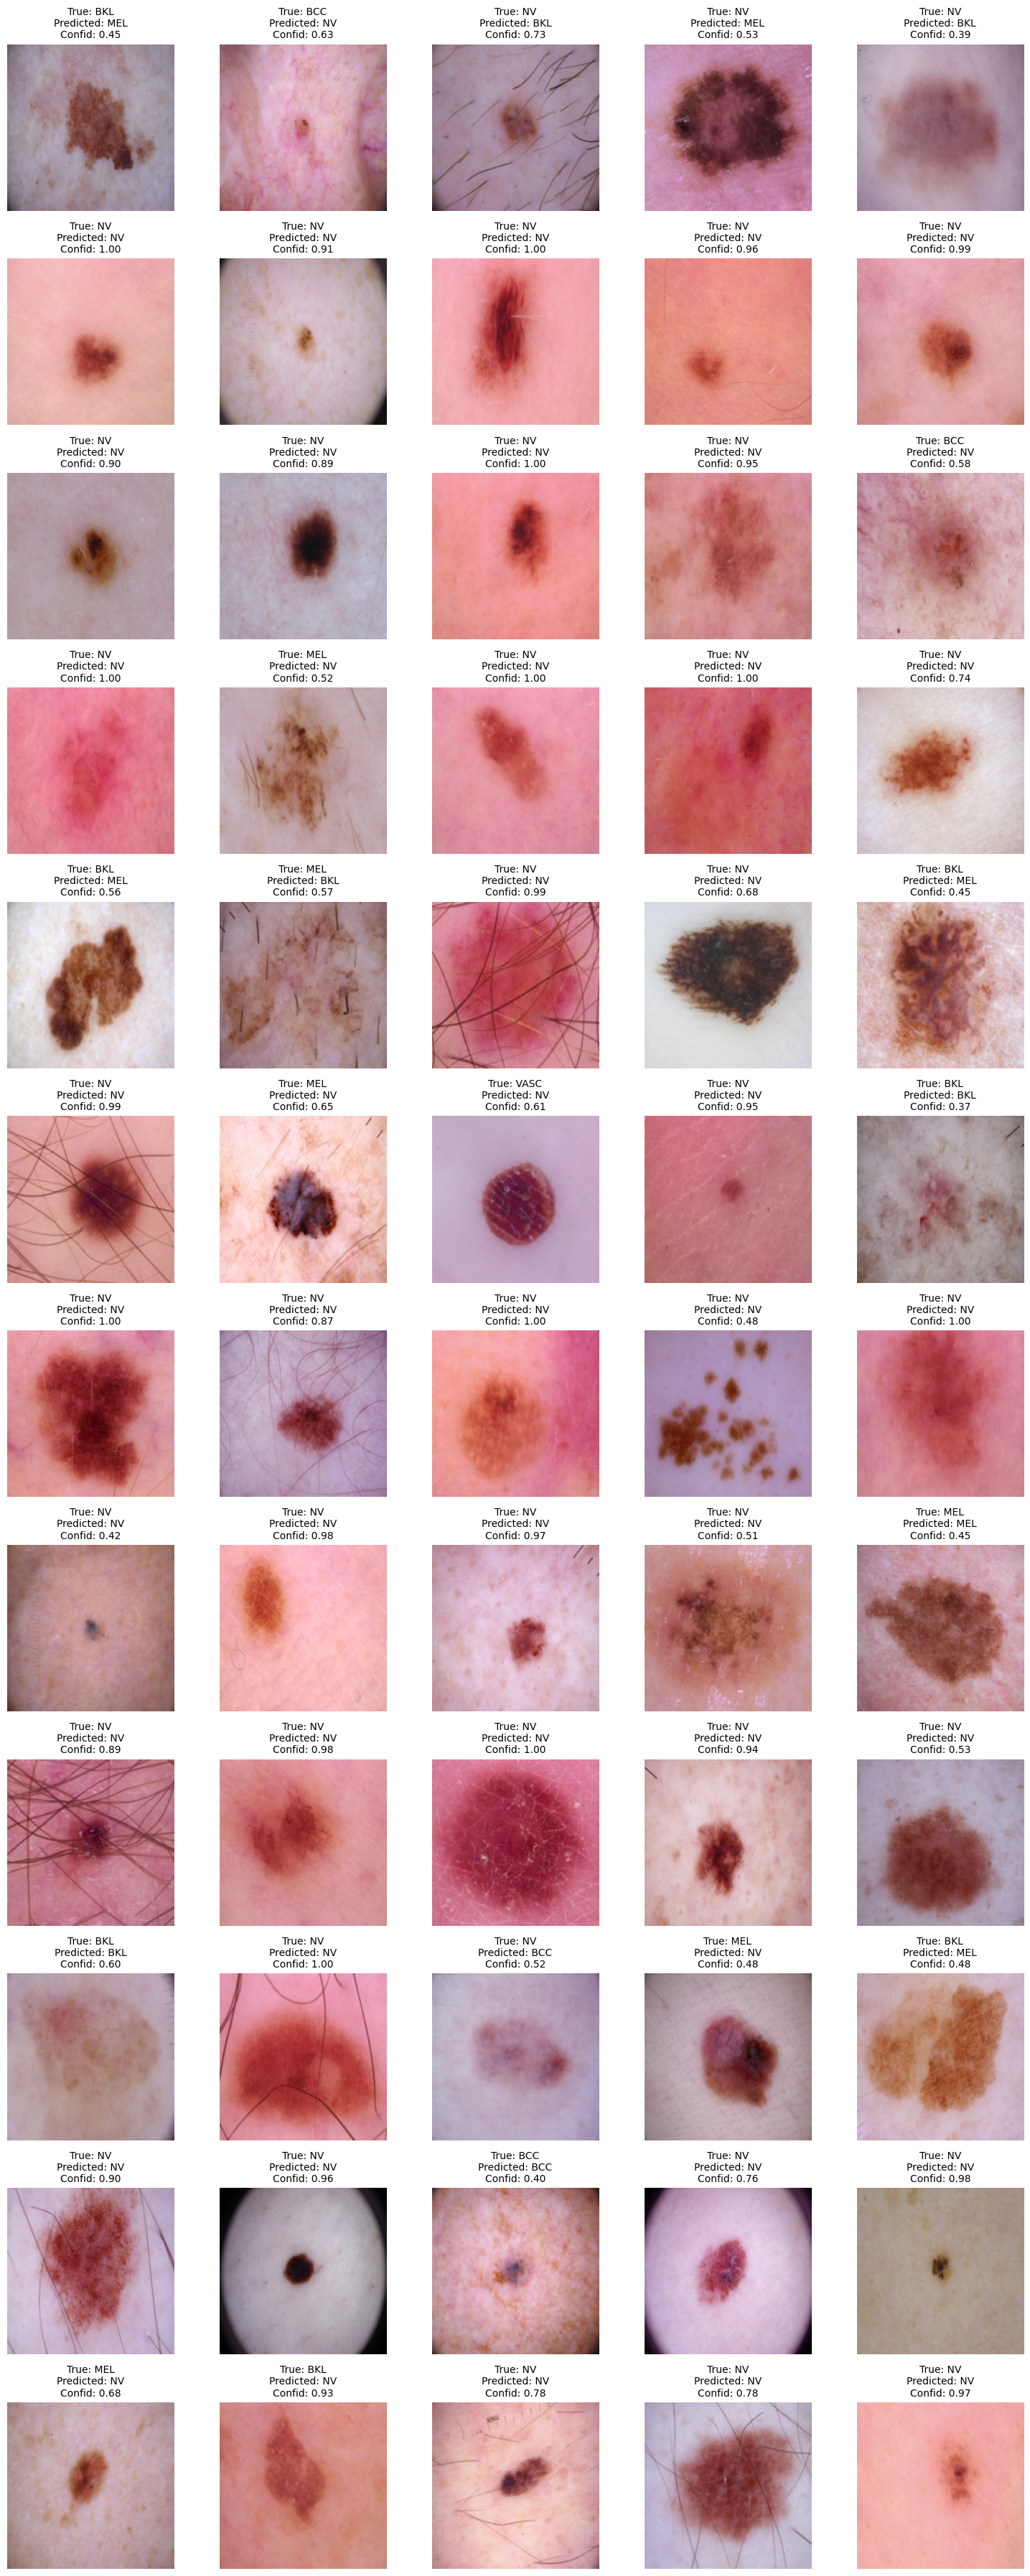

In [14]:
# Predict on the validation set
predictions = trainer.predict(model, dataloaders=val_loader)

# Combine predictions into a single tensor
predictions = torch.cat(predictions)

# Convert logits to probabilities and labels
probabilities = torch.softmax(predictions, dim=1)
predicted_labels = torch.argmax(probabilities, dim=1)

# Retrieve true labels and input images from the validation loader
val_images = []
val_labels = []

for batch in val_loader:
    inputs, labels = batch
    val_images.append(inputs)  # Store the images
    val_labels.append(labels)  # Store the true labels

# Combine images and labels into single tensors
val_images = torch.cat(val_images)
val_labels = torch.cat(val_labels)

# Display predictions for the first few images
def show_predictions(images, true_labels, predicted_labels, probabilities, class_names, num_rows=2, num_cols=5):
    """Displays predictions in a grid format with rows and columns."""
    plt.figure(figsize=(15, num_rows * 3))
    num_images = num_rows * num_cols
    for i in range(num_images):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        plt.imshow(img)
        true_label = class_names[true_labels[i].item()]
        predicted_label = class_names[predicted_labels[i].item()]
        confidence = probabilities[i][predicted_labels[i]].item()
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}\nConfid: {confidence:.2f}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

class_names = dataset.classes  # Get class names from the dataset

# Display a few rows of predictions
show_predictions(
    images=val_images,
    true_labels=val_labels,
    predicted_labels=predicted_labels,
    probabilities=probabilities,
    class_names=class_names,
    num_rows=12,  # Number of rows
    num_cols=5   # Number of columns
)

# What does the CNN see? (Optional)

In [15]:
import numpy as np
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to save activations and gradients
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """Hook to save activations (output of forward pass)."""
        self.activations = output

    def save_gradients(self, module, grad_in, grad_out):
        """Hook to save gradients (output of backward pass)."""
        self.gradients = grad_out[0]

    def generate_cam(self, input_tensor, class_idx=None):
        """Generate the Grad-CAM heatmap."""
        # Forward pass
        output = self.model(input_tensor)

        # Get the predicted class index if not provided
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        # Get gradients and activations
        gradients = self.gradients.cpu().detach().numpy()[0]
        activations = self.activations.cpu().detach().numpy()[0]

        # Global average pooling on gradients
        weights = np.mean(gradients, axis=(1, 2))

        # Compute Grad-CAM
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() if cam.max() != 0 else cam
        return cam

def visualize_cam(model, input_tensor, class_idx=None, target_layer=None):
    # Ensure model is in evaluation mode
    model.eval()

    # Generate Grad-CAM
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate_cam(input_tensor, class_idx)

    # Convert input tensor to numpy image
    input_image = input_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
    input_image = input_image - input_image.min()
    input_image = input_image / input_image.max()

    # Resize CAM to match image size
    cam_resized = cv2.resize(cam, (input_image.shape[1], input_image.shape[0]))

    # Overlay CAM on the image
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]
    overlay = (heatmap * 0.4 + input_image * 0.6)

    # Plot the results
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(input_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

/tmp/ipykernel_23/1376916509.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
/opt/conda/lib/python3.10/site-packages/torch/nn/mo

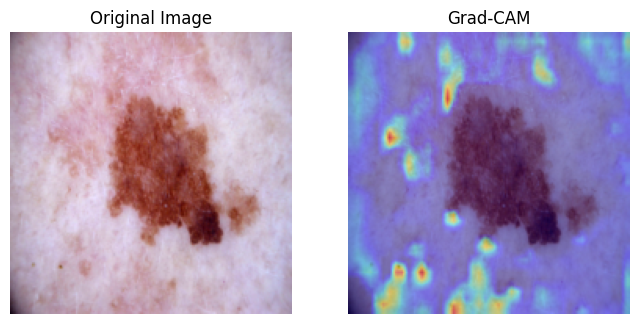

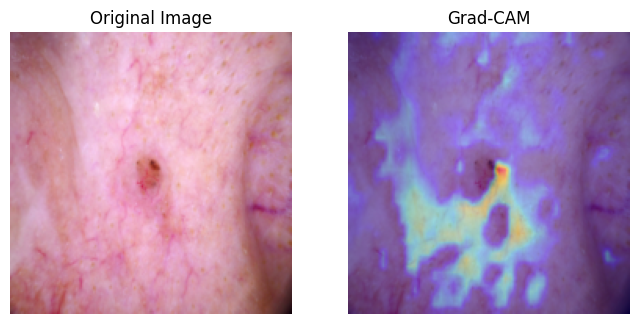

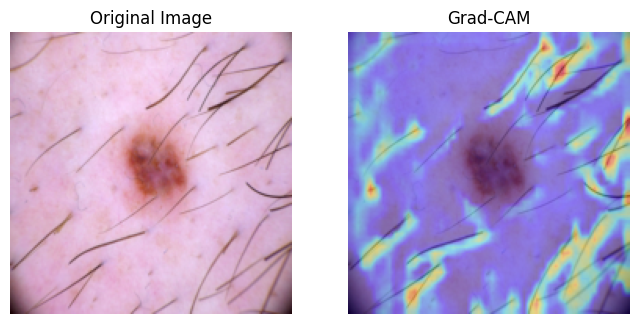

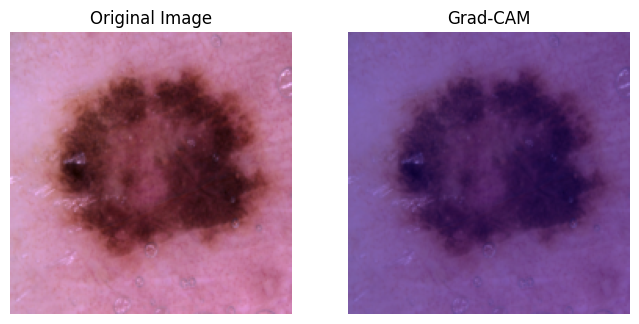

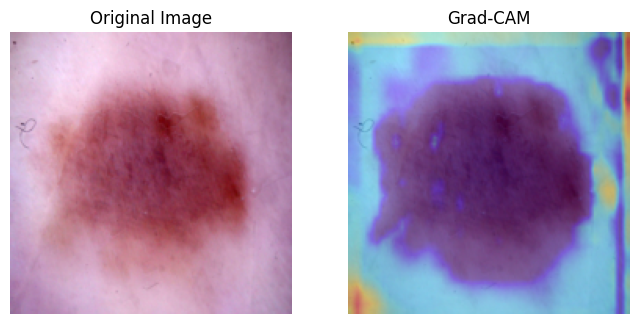

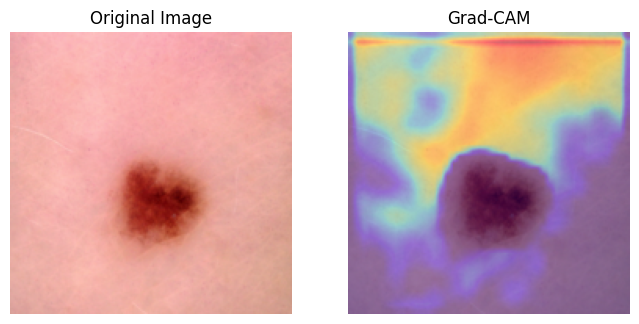

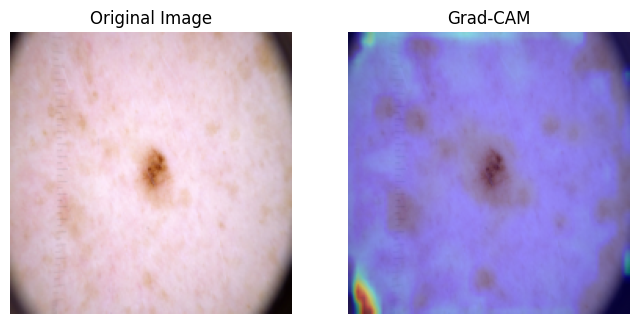

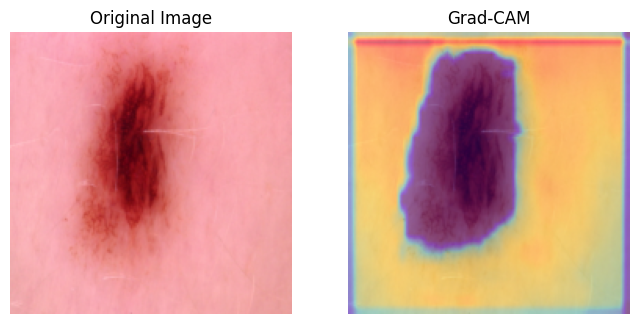

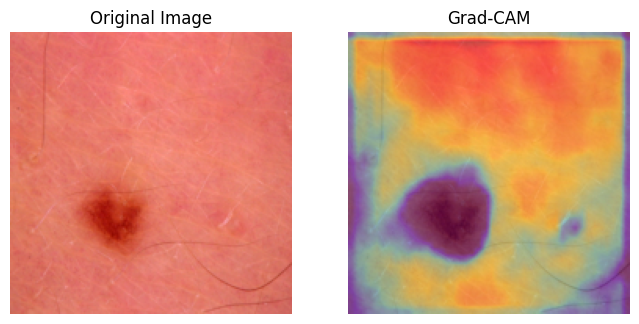

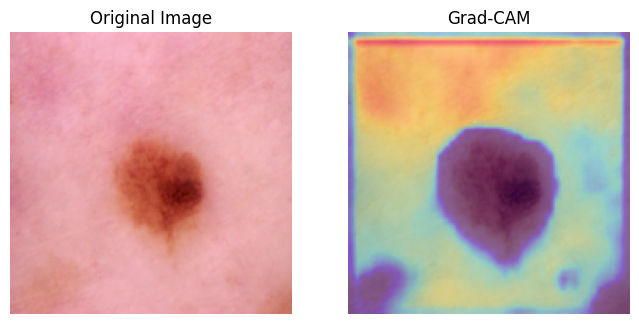

In [16]:
plot_grads = 10

for i in range(plot_grads):
    # Load the checkpoint
    checkpoint_path = "/kaggle/working/melanoma-model.ckpt"
    checkpoint = torch.load(checkpoint_path)

    # Extract the state_dict
    state_dict = checkpoint["state_dict"]

    # Remove the "model." prefix if necessary (depends on how the model was saved)
    state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

    # Initialize the model
    model = MelanomaClassifier(num_classes=num_classes)

    # Load the weights
    model.load_state_dict(state_dict)

    # Set the model to evaluation mode
    model.eval()

    # Single image from the validation set
    input_tensor = val_images[i].unsqueeze(0).to("cpu")  # Add batch dimension

    # Specify the target layer (last conv layer)
    target_layer = model.conv3

    # Generate and visualize Grad-CAM
    visualize_cam(model, input_tensor, class_idx=None, target_layer=target_layer)